In [1]:
# %%
import os
import numpy as np
from functools import partial
import math
from tqdm import tqdm
import time as time

import torch
M1 = False

if M1:
    device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
else:
    os.environ["CUDA_VISIBLE_DEVICES"]="1"
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    if torch.cuda.is_available():
        print(torch.cuda.is_available())
        print(torch.cuda.device_count())
        print(torch.cuda.current_device())
        print(torch.cuda.get_device_name(torch.cuda.current_device()))


from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from torchmetrics.functional import structural_similarity_index_measure 
from torchmetrics.functional import peak_signal_noise_ratio 

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import scipy.io as sio
from astropy.io import fits
import skimage as ski

import large_scale_UQ as luq
from large_scale_UQ.utils import to_numpy, to_tensor
from convex_reg import utils as utils_cvx_reg


True
1
0
NVIDIA A100-PCIE-40GB
Using device: cuda


In [3]:
# %%
# Optimisation options for the MAP estimation
options = {"tol": 1e-5, "iter": 14000, "update_iter": 4999, "record_iters": False}
# Save param
repo_dir = '/disk/xray0/tl3/repos/large-scale-UQ'
base_savedir = '/disk/xray0/tl3/outputs/large-scale-UQ/sampling/wavelets'
save_dir = base_savedir + '/vars/'
savefig_dir = base_savedir + '/figs/'

# %%
img_name = 'M31'

# Load img
img_path = repo_dir + '/data/imgs/{:s}.fits'.format(img_name)
img_data = fits.open(img_path, memmap=False)

# Loading the image and cast it to float
img = np.copy(img_data[0].data)[0,:,:].astype(np.float64)
# Flipping data
img = np.flipud(img)

# Aliases
x = img
ground_truth = img

# %%
# Load op from X Cai
op_mask = sio.loadmat(
    repo_dir + '/data/operators_masks/fourier_mask.mat'
)['Ma']

# Matlab's reshape works with 'F'-like ordering
mat_mask = np.reshape(np.sum(op_mask, axis=0), (256,256), order='F').astype(bool)

# Define my torch types
myType = torch.float64
myComplexType = torch.complex128

torch_img = torch.tensor(np.copy(img), dtype=myType, device=device).reshape((1,1) + img.shape)

# %%
phi = luq.operators.MaskedFourier_torch(
    shape=img.shape, 
    ratio=0.5 ,
    mask=mat_mask,
    norm='ortho',
    device=device
)


# Define X Cai noise level
sigma = 0.0024

y = phi.dir_op(torch_img).detach().cpu().squeeze().numpy()

# Generate noise
rng = np.random.default_rng(seed=0)
n = rng.normal(0, sigma, y[y!=0].shape)
# Add noise
y[y!=0] += n

# Observation
torch_y = torch.tensor(np.copy(y), device=device, dtype=myComplexType).reshape((1,) + img.shape)
x_init = torch.abs(phi.adj_op(torch_y))

# %%

# Define the likelihood
g = luq.operators.L2Norm_torch(
    sigma=sigma,
    data=torch_y,
    Phi=phi,
)
# Lipschitz constant computed automatically by g, stored in g.beta

# Define real prox
f = luq.operators.RealProx_torch()



In [4]:
# Iterate over
my_frac_delta = [0.98]
reg_params = [5e2] #, 5e1, 1e3, 5e3, 1e4, 5e4] # [5., 10., 20., 40.]

# Wavelet parameters
wavs_list = ['db8']
levels = 4

# LCI params
alpha_prob = 0.05

# Sampling alg params
frac_burnin = 0.1
n_samples = np.int64(5e4)
thinning = np.int64(1e1)
maxit = np.int64(n_samples * thinning * (1. + frac_burnin))
# SKROCK params
nStages = 10
eta = 0.05
dt_perc = 0.99


Threshold:  0.0028224005046845377
Running Base Forward Backward
[Forward Backward] 0 out of 14000 iterations, tol = 4.01e-01
[Forward Backward] converged in 226 iterations
Dirty
(PSNR: 27.45,
 SNR: 5.01, SSIM: 0.35)
Reconstruction
(PSNR: 49.15,
 SNR: 26.71, SSIM: 0.99)
Residual (x - x^hat)
(PSNR: 22.5,
 SNR: 0.06, SSIM: 0.77)


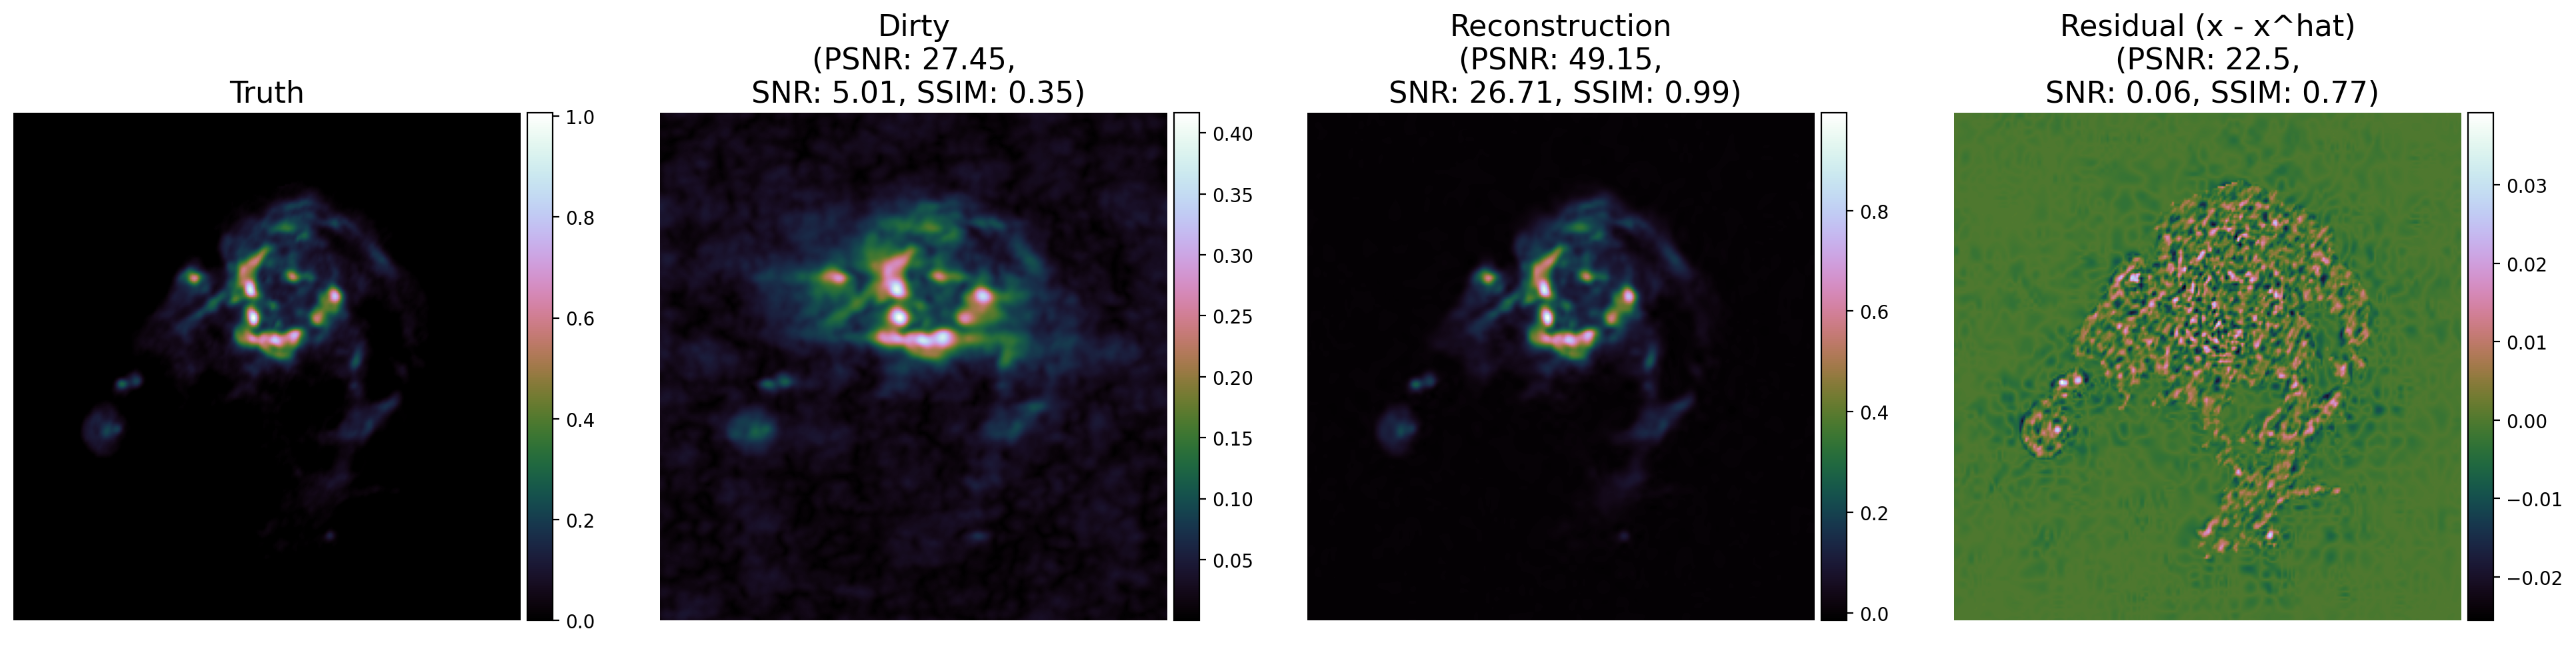

Calculating credible interval for superpxiel:  (256, 256)
[Bisection Method] There is no root in this range.
[Bisection Method] There is no root in this range.
[Bisection Method] There is no root in this range.
[Bisection Method] There is no root in this range.
[Bisection Method] There is no root in this range.
[Bisection Method] There is no root in this range.
[Bisection Method] There is no root in this range.
[Bisection Method] There is no root in this range.
[Bisection Method] There is no root in this range.
[Bisection Method] There is no root in this range.
[Bisection Method] There is no root in this range.
[Bisection Method] There is no root in this range.
[Bisection Method] There is no root in this range.
[Bisection Method] There is no root in this range.
[Bisection Method] There is no root in this range.
[Bisection Method] There is no root in this range.
[Bisection Method] There is no root in this range.
[Bisection Method] There is no root in this range.
[Bisection Method] There

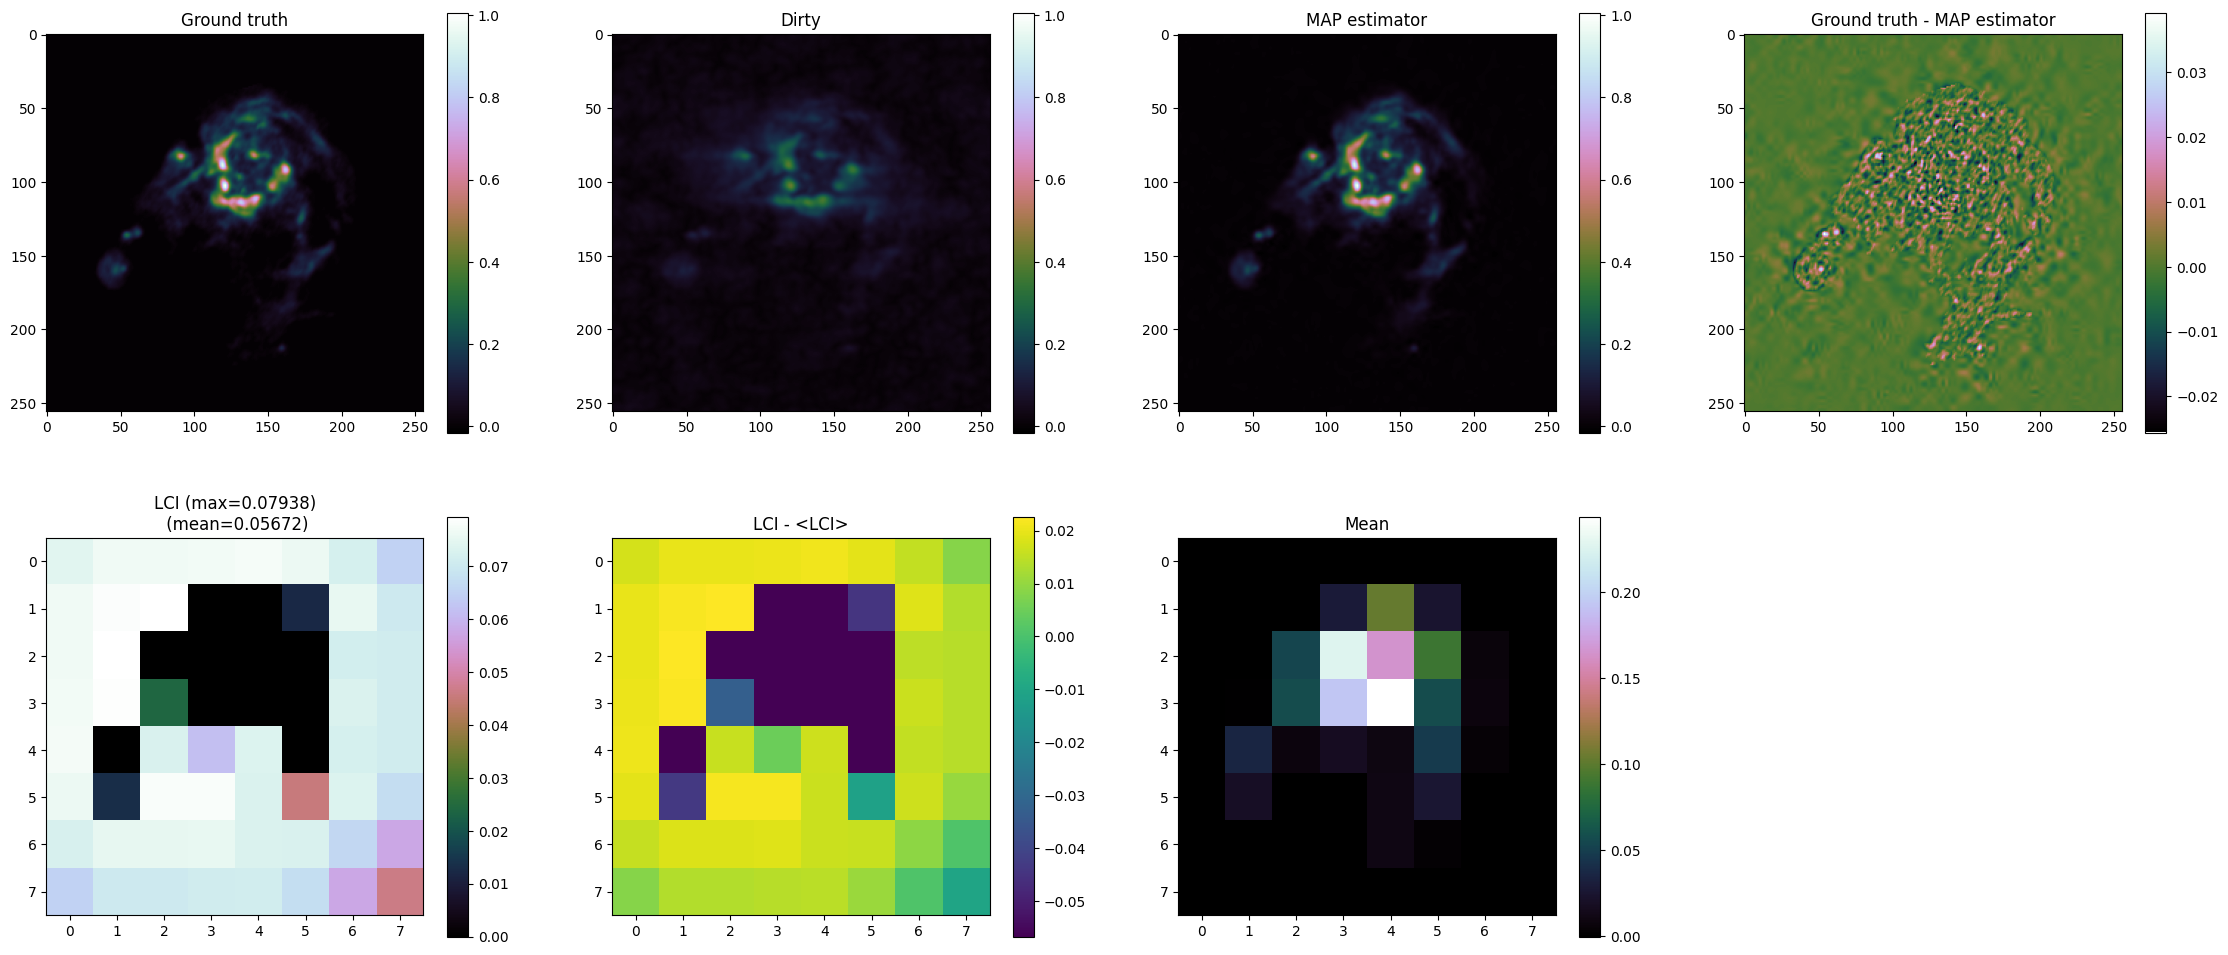

Calculating credible interval for superpxiel:  (256, 256)
[Bisection Method] There is no root in this range.
[Bisection Method] There is no root in this range.
[Bisection Method] There is no root in this range.
[Bisection Method] There is no root in this range.
[Bisection Method] There is no root in this range.
[Bisection Method] There is no root in this range.
[Bisection Method] There is no root in this range.
[Bisection Method] There is no root in this range.
[Bisection Method] There is no root in this range.
[Bisection Method] There is no root in this range.
[Bisection Method] There is no root in this range.
[Bisection Method] There is no root in this range.
[Bisection Method] There is no root in this range.
[Bisection Method] There is no root in this range.
[Bisection Method] There is no root in this range.
[Bisection Method] There is no root in this range.
[Bisection Method] There is no root in this range.
[Bisection Method] There is no root in this range.
[Bisection Method] There

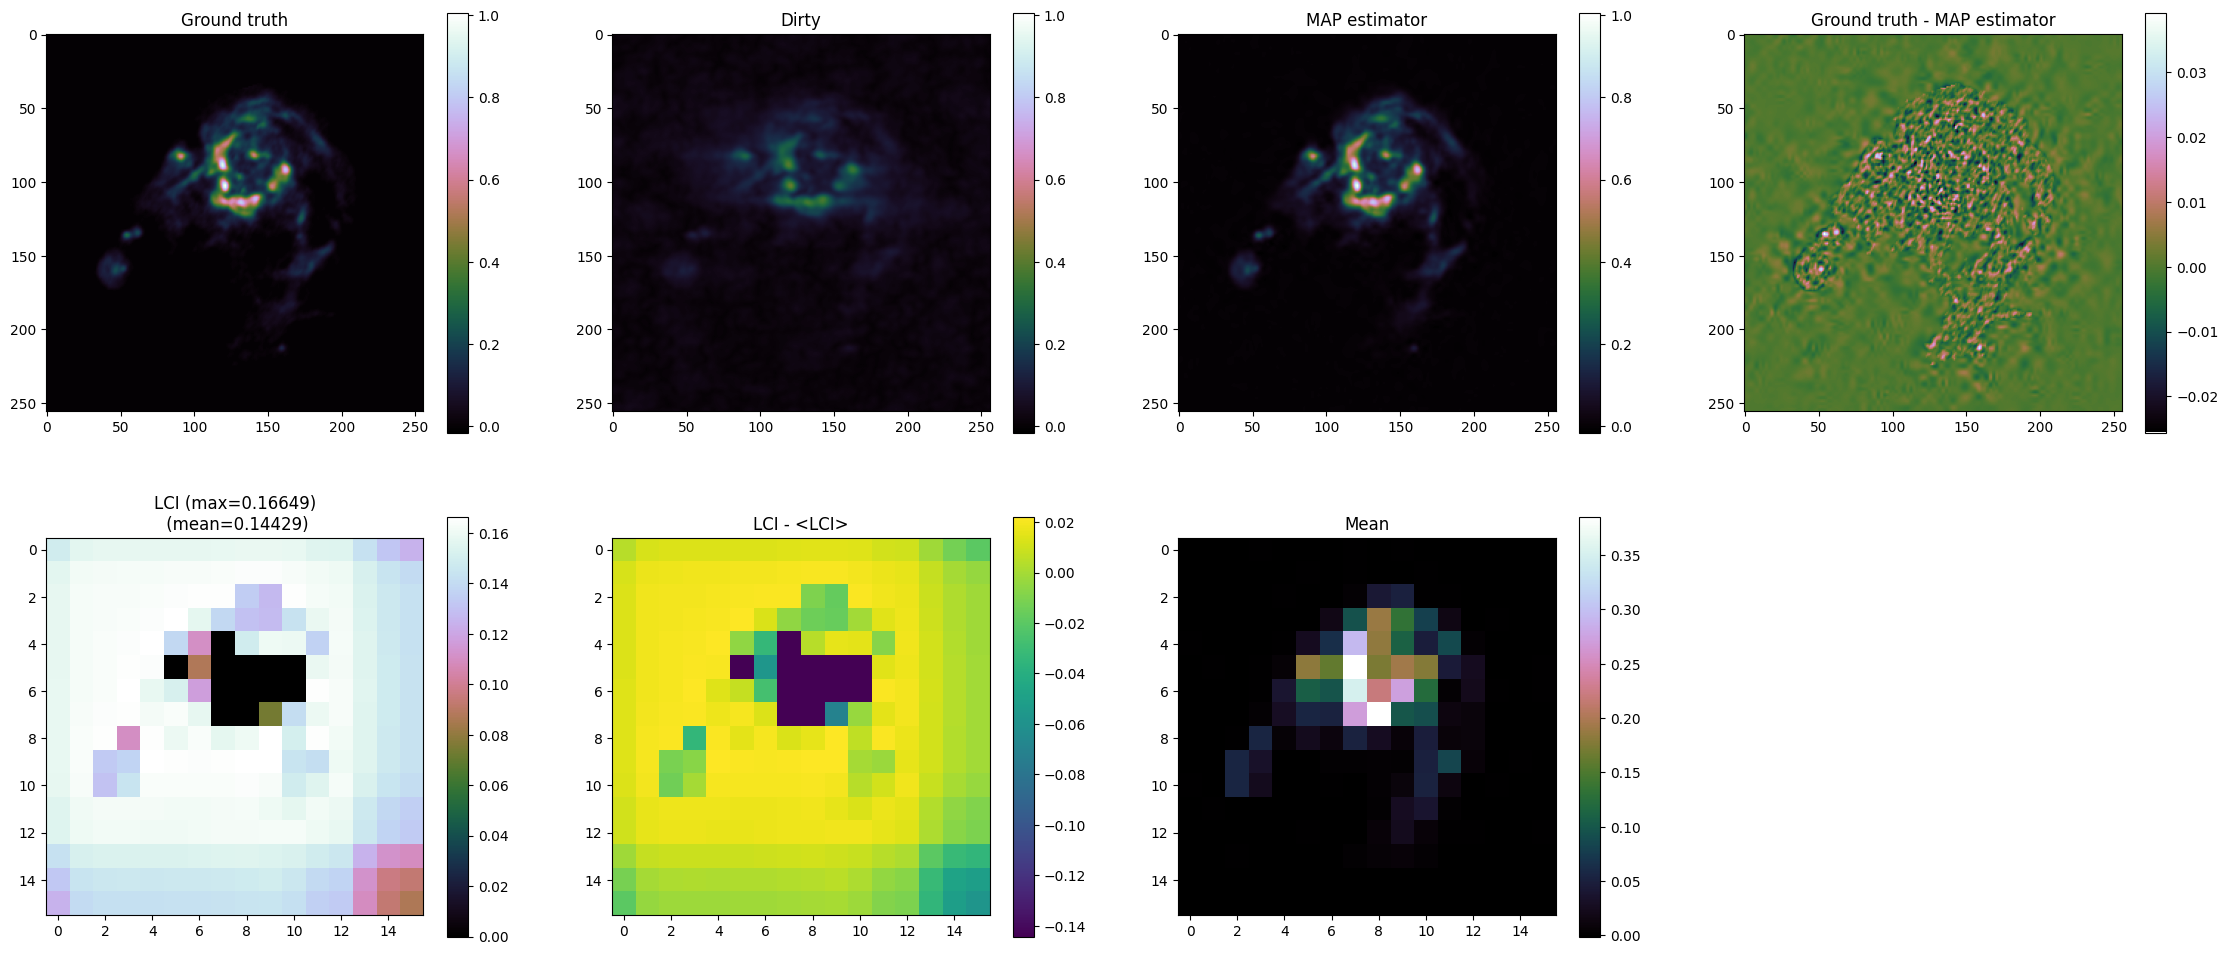

Calculating credible interval for superpxiel:  (256, 256)
[Bisection Method] There is no root in this range.
[Bisection Method] There is no root in this range.
[Bisection Method] There is no root in this range.
[Bisection Method] There is no root in this range.


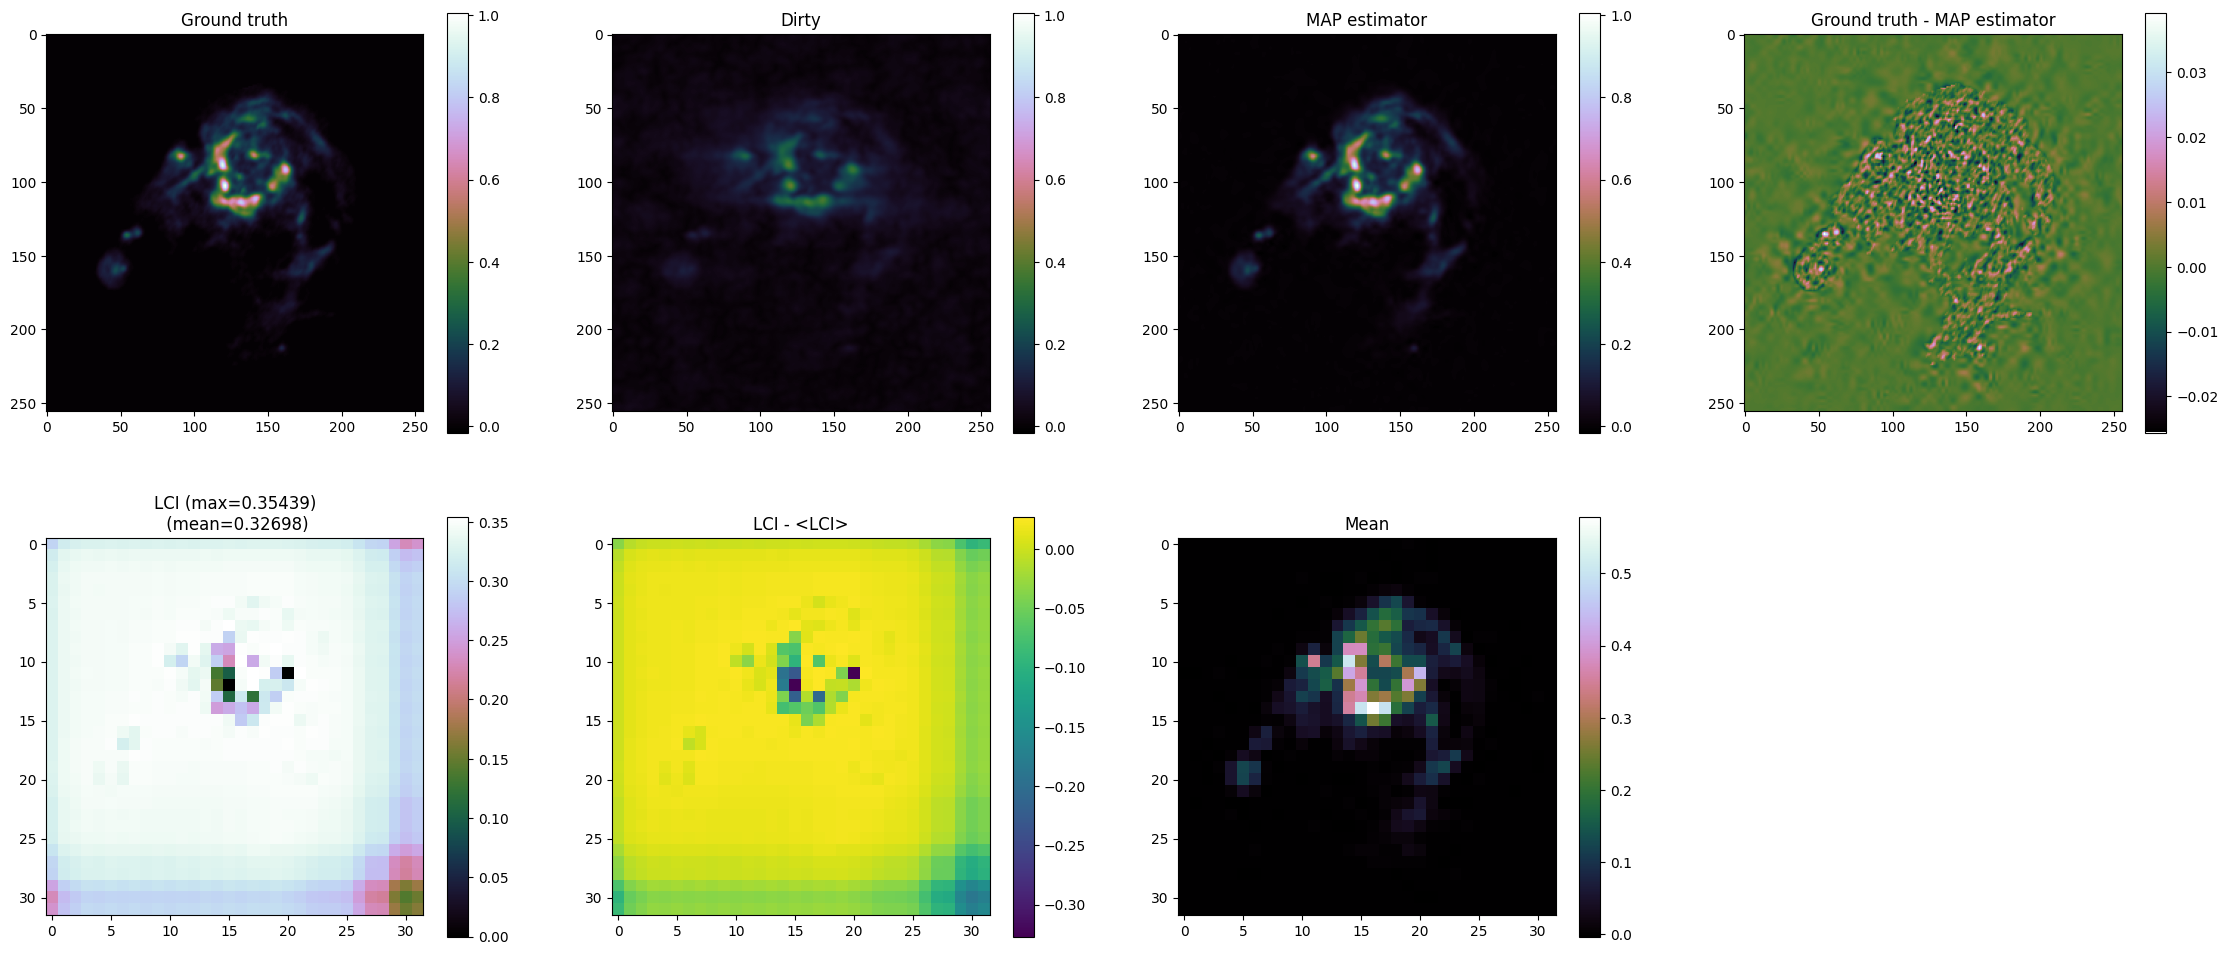

Calculating credible interval for superpxiel:  (256, 256)


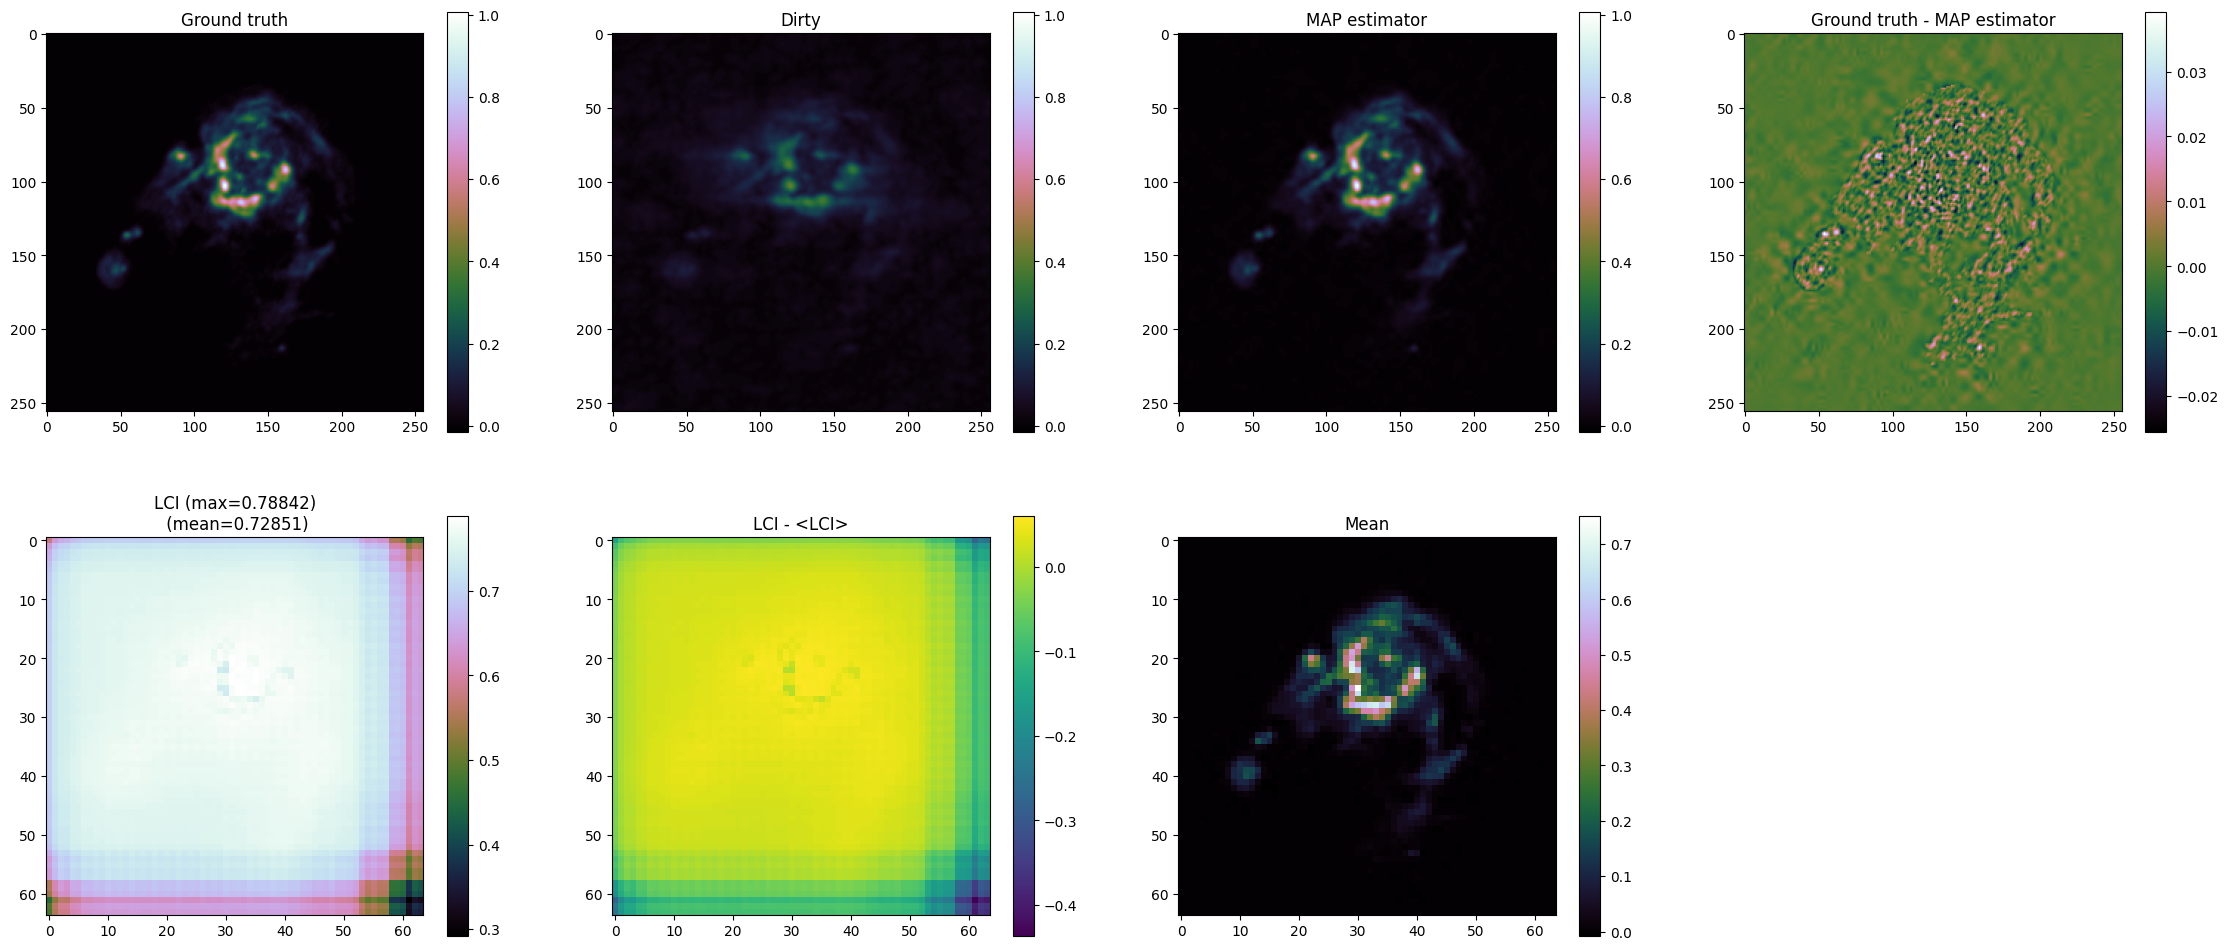

f(x_map):  10793.147409250432 
g(x_map):  156180.91242069422 
tau_alpha*np.sqrt(N):  2072.011448732029 
N:  65536
tau_alpha:  8.093794721609488
gamma_alpha:  234582.07127867668


In [5]:

for it_param, reg_param in enumerate(reg_params):

    # Define the wavelet dict
    # Define the l1 norm with dict psi
    psi = luq.operators.DictionaryWv_torch(wavs_list, levels)

    h = luq.operators.L1Norm_torch(1., psi, op_to_coeffs=True)
    # gamma = h._get_max_abs_coeffs(h.dir_op(torch.clone(x_init))) * reg_param
    # h.gamma = gamma
    h.gamma = reg_param
    # Compute stepsize
    alpha = 0.98 / g.beta

    # Effective threshold
    print('Threshold: ', h.gamma * alpha)

    # Run the optimisation
    x_hat, diagnostics = luq.optim.FB_torch(
        x_init,
        options=options,
        g=g,
        f=f,
        h=h,
        alpha=alpha,
        tau=alpha,
        viewer=None
    )


    # %%
    np_x_init = to_numpy(x_init)
    np_x = np.copy(x)
    np_x_hat = to_numpy(x_hat)


    # %%
    images = [np_x, np_x_init, np_x_hat, np_x - np.abs(np_x_hat)]
    labels = ["Truth", "Dirty", "Reconstruction", "Residual (x - x^hat)"]
    fig, axs = plt.subplots(1,4, figsize=(24,6), dpi=200)
    for i in range(4):
        im = axs[i].imshow(images[i], cmap='cubehelix', vmax=np.nanmax(images[i]), vmin=np.nanmin(images[i]))
        divider = make_axes_locatable(axs[i])
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im, cax=cax, orientation='vertical')
        if i > 0:   
            stats_str = '\n(PSNR: {},\n SNR: {}, SSIM: {})'.format(
                round(psnr(ground_truth, images[i], data_range=ground_truth.max()-ground_truth.min()), 2),
                round(luq.utils.eval_snr(x, images[i]), 2),
                round(ssim(ground_truth, images[i], data_range=ground_truth.max()-ground_truth.min()), 2),
                )
            labels[i] += stats_str
            print(labels[i])
        axs[i].set_title(labels[i], fontsize=16)
        axs[i].axis('off')
    # plt.savefig('{:s}{:s}_SKROCK_wavelets_reg_param_{:.1e}_optim_MAP.pdf'.format(savefig_dir, img_name, reg_param))
    # plt.close()
    plt.show()

    ### MAP-based UQ

    # Define prior potential
    fun_prior = lambda _x : h._fun_coeffs(h.dir_op(_x))
    # Define posterior potential
    loss_fun_torch = lambda _x : g.fun(_x) +  fun_prior(_x)
    # Numpy version of the posterior potential
    loss_fun_np = lambda _x : g.fun(
        luq.utils.to_tensor(_x, dtype=myType)
    ).item() +  fun_prior(luq.utils.to_tensor(_x, dtype=myType)).item()

    # Compute HPD region bound
    N = np_x_hat.size
    tau_alpha = np.sqrt(16*np.log(3/alpha_prob))
    gamma_alpha = loss_fun_torch(x_hat).item() + tau_alpha*np.sqrt(N) + N


    # Compute the LCI
    superpix_sizes = [32, 16, 8, 4]
    LCI_iters = 200
    LCI_tol = 1e-4
    LCI_bottom = -10
    LCI_top = 10

    error_p_arr = []
    error_m_arr = []
    mean_img = []
    computing_time = []

    x_init_np = luq.utils.to_numpy(x_init)

    # Define prefix
    save_MAP_prefix = 'wavelets_UQ_MAP_reg_param_{:.1e}'.format(reg_param)

    for superpix_size in superpix_sizes:

        pr_time_1 = time.process_time()
        wall_time_1 = time.time()

        error_p, error_m, mean = luq.map_uncertainty.create_local_credible_interval(
            x_sol=np_x_hat,
            region_size=superpix_size,
            function=loss_fun_np,
            bound=gamma_alpha,
            iters=LCI_iters,
            tol=LCI_tol,
            bottom=LCI_bottom,
            top=LCI_top,
        )
        error_length = error_p - error_m

        pr_time_2 = time.process_time()
        wall_time_2 = time.time()

        error_p_arr.append(np.copy(error_p))
        error_m_arr.append(np.copy(error_m))
        mean_img.append(np.copy(mean))
        computing_time.append((
            pr_time_2 - pr_time_1, 
            wall_time_2 - wall_time_1
        ))

        vmin = np.min((x, x_init_np, np_x_hat))
        vmax = np.max((x, x_init_np, np_x_hat))
        # err_vmax= 0.6
        cmap='cubehelix'

        plt.figure(figsize=(28,12))
        plt.subplot(241)
        plt.imshow(x, cmap=cmap, vmin=vmin, vmax=vmax);plt.colorbar()
        plt.title('Ground truth')
        plt.subplot(242)
        plt.imshow(x_init_np, cmap=cmap, vmin=vmin, vmax=vmax);plt.colorbar()
        plt.title('Dirty')
        plt.subplot(243)
        plt.imshow(np_x_hat, cmap=cmap, vmin=vmin, vmax=vmax);plt.colorbar()
        plt.title('MAP estimator')
        plt.subplot(244)
        plt.imshow(x - np_x_hat, cmap=cmap);plt.colorbar()
        plt.title('Ground truth - MAP estimator')
        plt.subplot(245)
        plt.imshow(error_length, cmap=cmap);plt.colorbar()
        plt.title('LCI (max={:.5f})\n (mean={:.5f})'.format(
            np.max(error_length), np.mean(error_length))
        )
        plt.subplot(246)
        plt.imshow(error_length - np.mean(error_length), cmap='viridis');plt.colorbar()
        plt.title('LCI - <LCI>')
        plt.subplot(247)
        plt.imshow(mean, cmap=cmap);plt.colorbar();plt.title('Mean')
        # plt.savefig(
        #     savefig_dir+save_MAP_prefix+'_UQ-MAP_pixel_size_{:d}.pdf'.format(superpix_size)
        # )
        # plt.close()
        plt.show()

    print(
        'f(x_map): ', g.fun(x_hat).item(),
        '\ng(x_map): ', fun_prior(x_hat).item(),
        '\ntau_alpha*np.sqrt(N): ', tau_alpha*np.sqrt(N),
        '\nN: ', N,
    )
    print('tau_alpha: ', tau_alpha)
    print('gamma_alpha: ', gamma_alpha.item())



In [6]:
# Compute ground truth block 
gt_block_imgs = []
for superpix_size in superpix_sizes:

    block_image = ski.measure.block_reduce(
        np.copy(img), block_size=(superpix_size, superpix_size), func=np.mean
    )
    gt_block_imgs.append(block_image)



In [7]:

# error_length = error_p - error_m
# error_p_arr.append(np.copy(error_p))
# error_m_arr.append(np.copy(error_m))

len(error_p_arr)


4

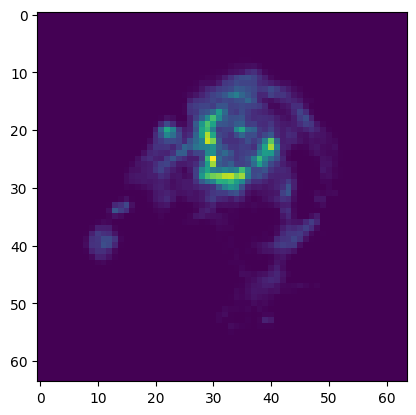

In [41]:
plt.figure()
plt.imshow(gt_block_imgs[3])



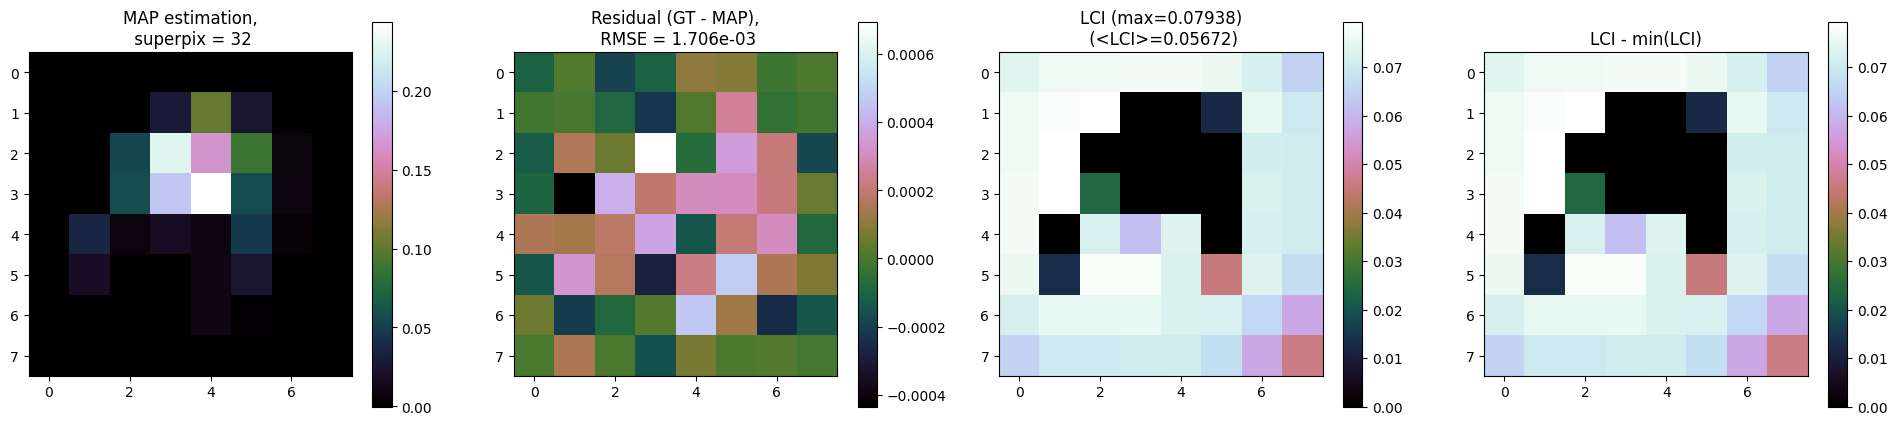

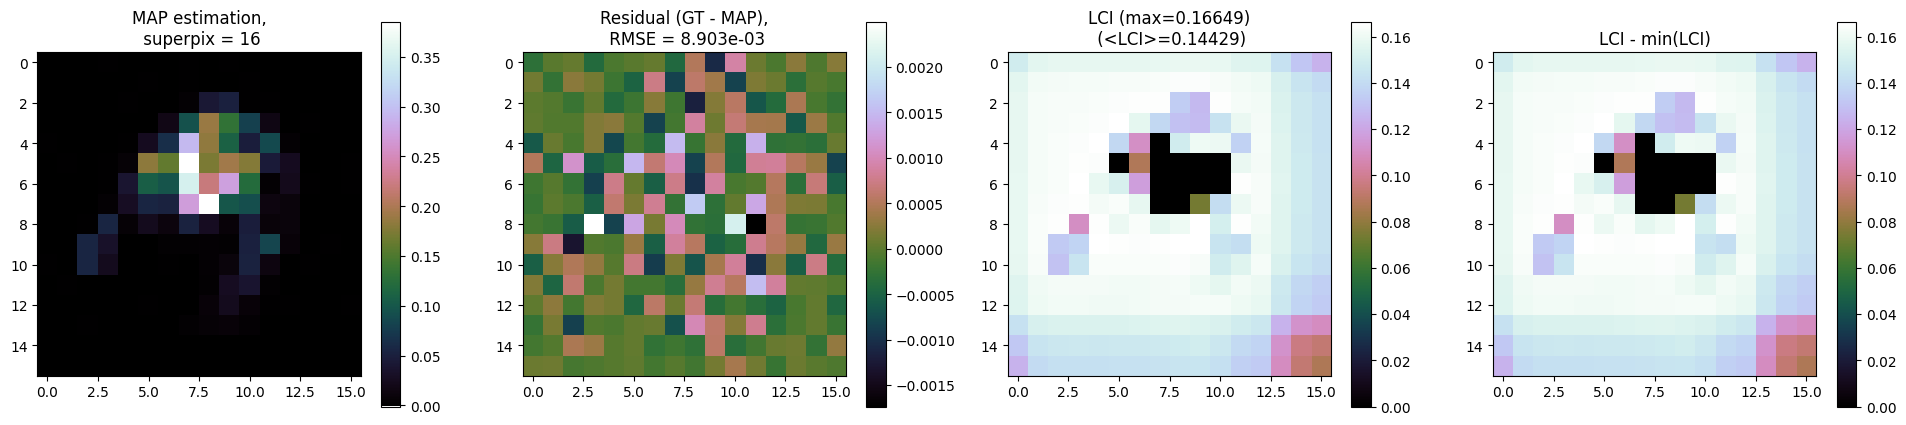

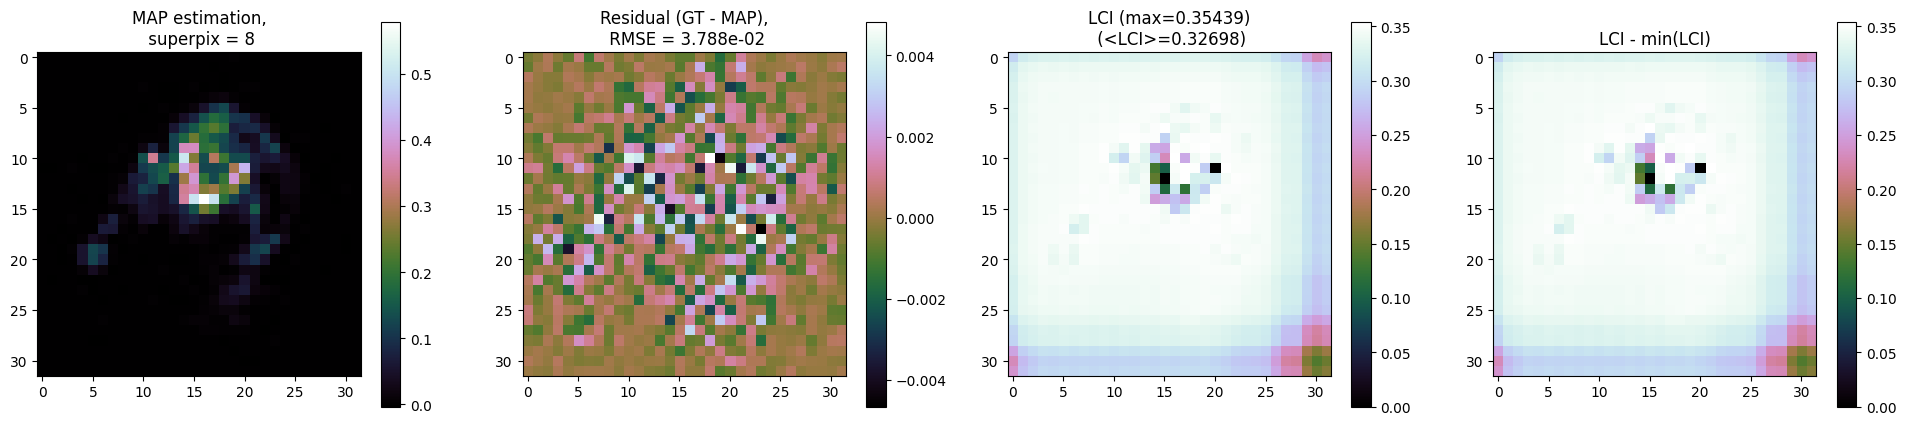

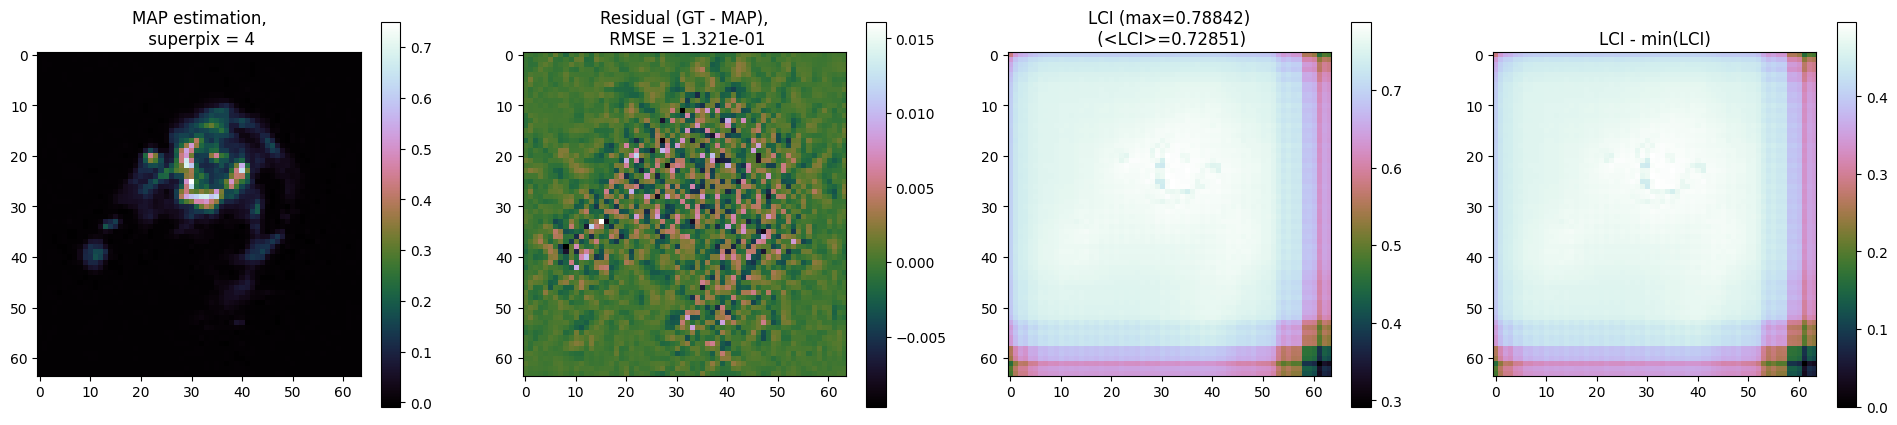

In [10]:
for it in range(len(error_p_arr)):

    error_length = error_p_arr[it] - error_m_arr[it]
    superpix_size = superpix_sizes[it]
    mean = mean_img[it]
    gt_mean = gt_block_imgs[it]

    # cmap='magma'
    cmap = 'cubehelix'

    plt.figure(figsize=(24,5))
    plt.subplot(141)
    plt.imshow(mean, cmap=cmap);plt.colorbar()
    plt.title('MAP estimation,\n superpix = {:d}'.format(superpix_size))
    plt.subplot(142)
    plt.imshow(gt_mean - mean, cmap=cmap);plt.colorbar()
    plt.title('Residual (GT - MAP),\n RMSE = {:.3e}'.format(np.sqrt(np.sum((gt_mean - mean)**2))))
    plt.subplot(143)
    plt.imshow(error_length, cmap=cmap);plt.colorbar()
    plt.title('LCI (max={:.5f})\n (<LCI>={:.5f})'.format(
        np.max(error_length), np.mean(error_length))
    )
    plt.subplot(144)
    plt.imshow(error_length - np.min(error_length), cmap=cmap);plt.colorbar()
    plt.title('LCI - min(LCI)')
    plt.savefig(
        savefig_dir+save_MAP_prefix+'_UQ-MAP_pixel_size_{:d}_nice_pic.pdf'.format(superpix_size)
    )
    # plt.close()
    plt.show()



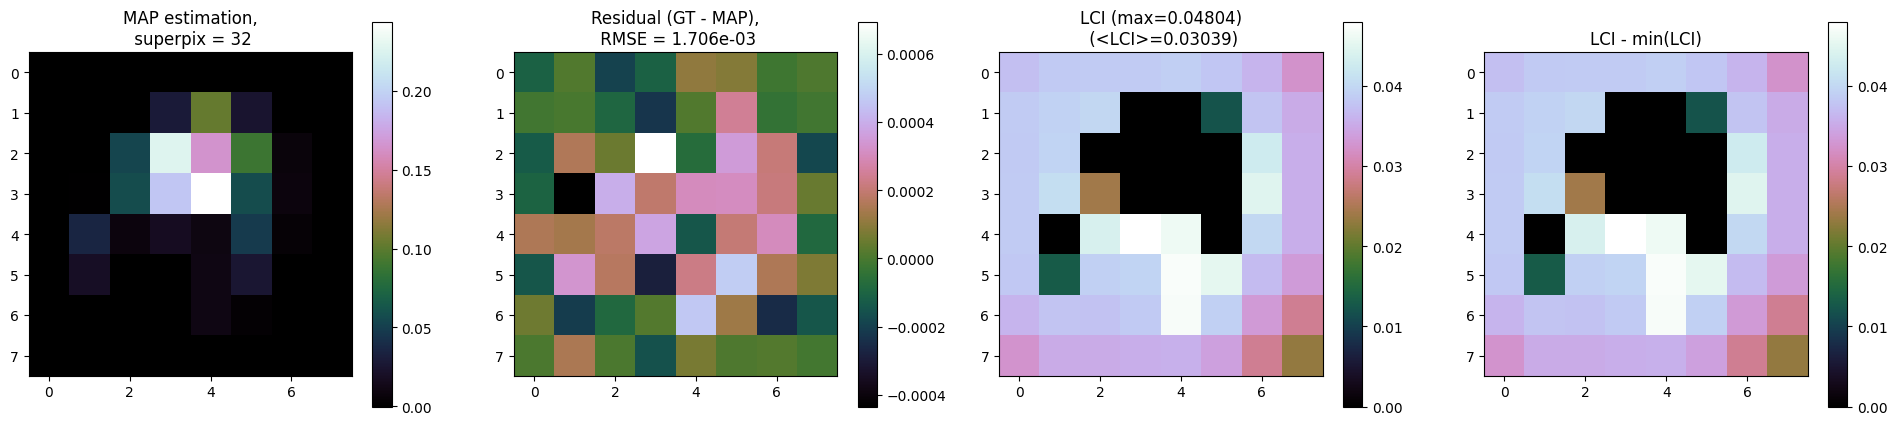

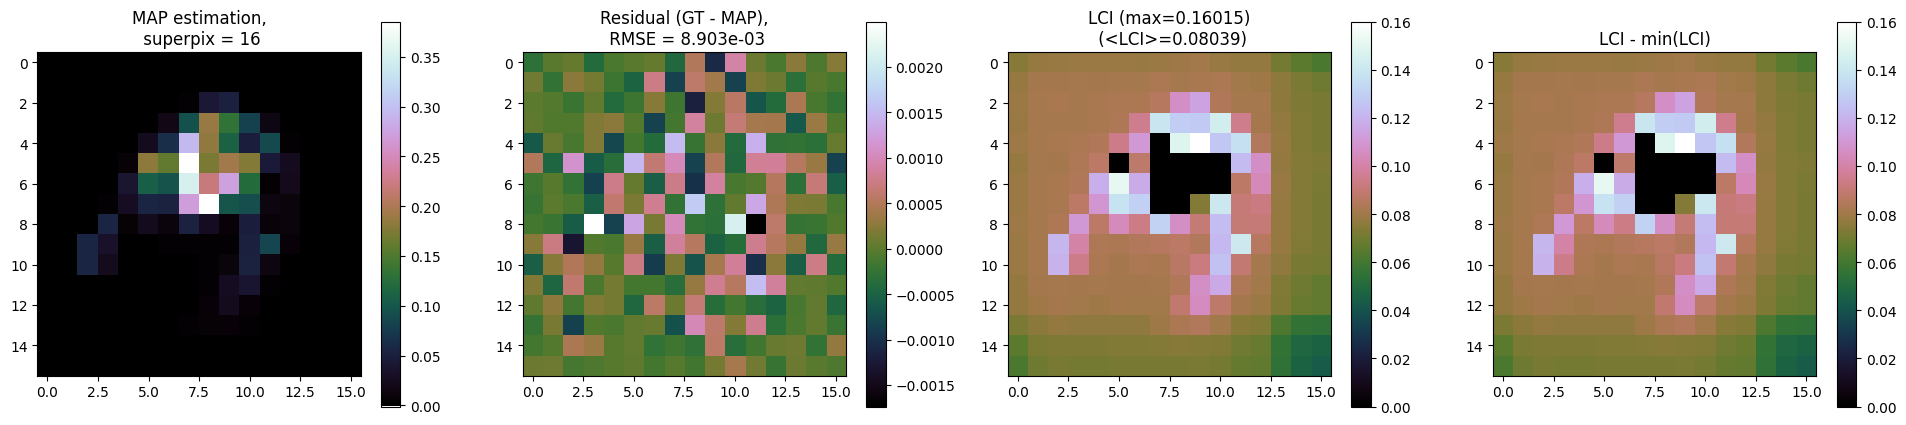

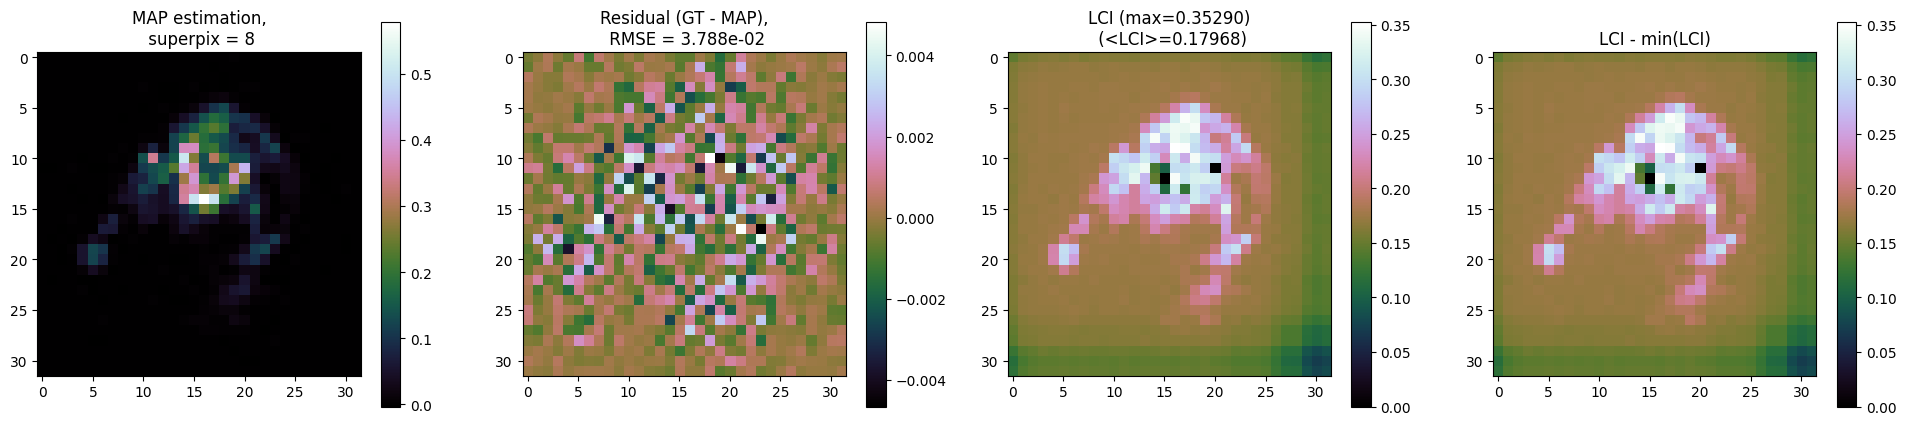

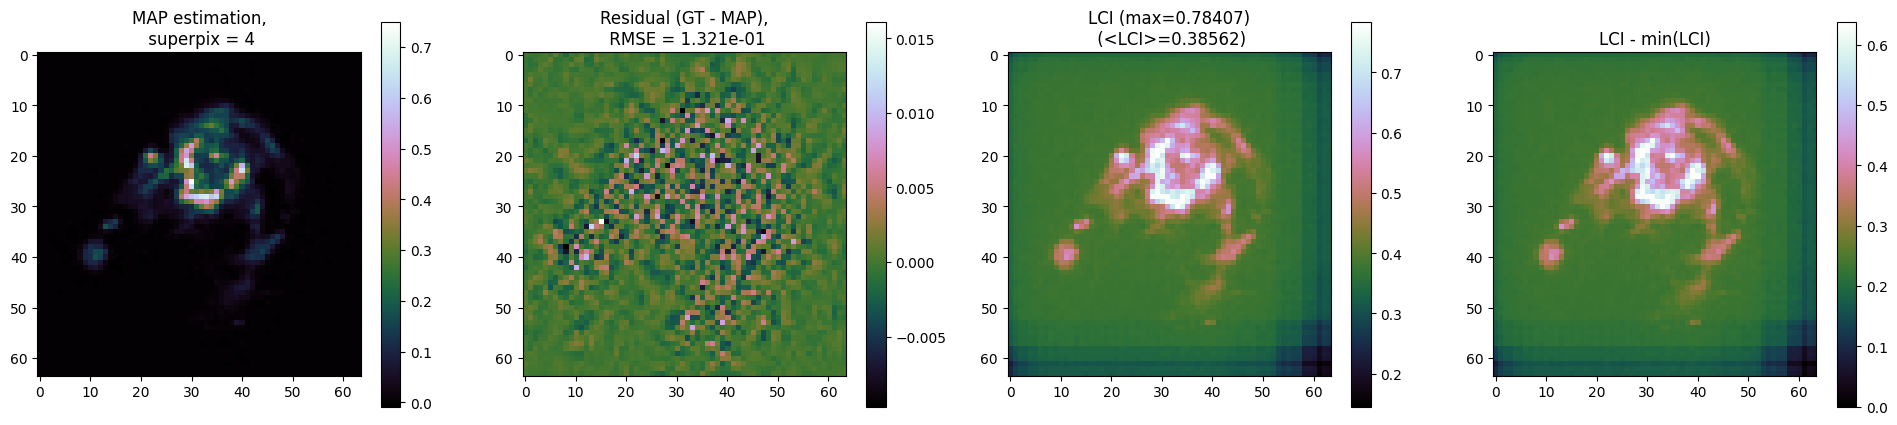

In [11]:
for it in range(len(error_p_arr)):

    error_p = np.copy(error_p_arr[it])
    error_m =  np.copy(error_m_arr[it])

    def clip_vals(mat):
        mat[mat<0] = 0
        mat[mat>=1.] = 1.
        return mat

    error_length = clip_vals(error_p) - clip_vals(error_m)
    superpix_size = superpix_sizes[it]
    mean = mean_img[it]
    gt_mean = gt_block_imgs[it]

    # cmap='magma'
    cmap = 'cubehelix'

    plt.figure(figsize=(24,5))
    plt.subplot(141)
    plt.imshow(mean, cmap=cmap);plt.colorbar()
    plt.title('MAP estimation,\n superpix = {:d}'.format(superpix_size))
    plt.subplot(142)
    plt.imshow(gt_mean - mean, cmap=cmap);plt.colorbar()
    plt.title('Residual (GT - MAP),\n RMSE = {:.3e}'.format(np.sqrt(np.sum((gt_mean - mean)**2))))
    plt.subplot(143)
    plt.imshow(error_length, cmap=cmap);plt.colorbar()
    plt.title('LCI (max={:.5f})\n (<LCI>={:.5f})'.format(
        np.max(error_length), np.mean(error_length))
    )
    plt.subplot(144)
    plt.imshow(error_length - np.min(error_length), cmap=cmap);plt.colorbar()
    plt.title('LCI - min(LCI)')
    plt.savefig(
        savefig_dir+save_MAP_prefix+'_UQ-MAP_pixel_size_{:d}_nice_pic_clipped.pdf'.format(superpix_size)
    )
    # plt.close()
    plt.show()